## TIRF analysis ***INTERACTIVE*** 
Python programs for analysis of single molecule TIRF

Developed by Charles Bayly-Jones (2022) 
Monash University, Melbourne, Australia

In [1]:
import os
import numpy as np
from TIRF_tools import *
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from matplotlib import cm

import cv2
import math

from algorithms import *
from skimage.restoration import denoise_tv_chambolle

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: ignored

## Define parameters and functions

In [ ]:
input = 'date/run_1_b/'
gain_ref = 'date/gain_ref.tiff'
liposome_decay = 2.25e-3
protein_decay = 1.87e-2
dt = 5

## Preprocess raw ONI output

In [ ]:
def multi_colour_preprocess(input, gain_ref):
    gain_ref = read(gain_ref, full=True)

    batch = []
    if os.path.isdir(input):
        for root, _, filenames in os.walk(input):
            if os.path.split(root)[-1][0:3] == 'pos':
                print(f'Working on {root}')
                dir_base = os.path.split(root)[0]
                new = 'analysis' + os.path.split(root)[-1][3:]
                out = os.path.join(dir_base, new)
                if not os.path.isdir(out):
                    os.makedirs(out)
                print(f'Output in {out}')
                
                f0, l0 = [], []
                f1, l1 = [], []
                for file in filenames:
                    base = file.split('_')
                    if base[-1].split('.')[1] == 'tif':
                        for ind, radical in enumerate(base):
                            if radical[:6] == 'colour':
                                colour = int(radical[6:7])
                            if radical[0] == 't':
                                time = int(radical[1:])
       
                        if colour == 0:
                            f0.append(file)
                            l0.append(time)
                        else:
                            f1.append(file)
                            l1.append(time)
                        
                l0sort = sorted(range(len(l0)), key=lambda k: l0[k])
                l1sort = sorted(range(len(l1)), key=lambda k: l1[k])      
    
                ch0_stack = []
                for index in l0sort:
                    img = os.path.join(root, f0[index])
                    arr = read(img, full=True)[:,0:427] - gain_ref[:,0:427]
                    #mean = np.average(arr)
                    #arr[arr > 5 * mean] = 1
                    ch0_stack.append(arr)
                    
                ch1_stack = []
                for index in l1sort:
                    img = os.path.join(root, f1[index])
                    arr = read(img, full=True)[:,428:855] - gain_ref[:,428:855]
                    #mean = np.average(arr)
                    #arr[arr > 5 * mean] = 1
                    ch1_stack.append(arr)

                write(average(np.array(ch0_stack)), os.path.join(out,'ch0_average.tiff'))
                write(average(np.array(ch1_stack)), os.path.join(out,'ch1_average.tiff'))

                write(np.array(ch0_stack), os.path.join(out,'ch0_stack.tiff'))
                write(np.array(ch1_stack), os.path.join(out,'ch1_stack.tiff'))
                
                batch.append([os.path.join(out,'ch0_stack.tiff'),os.path.join(out,'ch1_stack.tiff'), out])
                
    return batch
        
batch = multi_colour_preprocess(input, gain_ref)
print(batch)

Working on date/run_1_b/pos_0
Output in date/run_1_b/analysis_0
Working on date/run_1_b/pos_3
Output in date/run_1_b/analysis_3
Working on date/run_1_b/pos_2
Output in date/run_1_b/analysis_2
Working on date/run_1_b/pos_1
Output in date/run_1_b/analysis_1
[['date/run_1_b/analysis_0/ch0_stack.tiff', 'date/run_1_b/analysis_0/ch1_stack.tiff', 'date/run_1_b/analysis_0'], ['date/run_1_b/analysis_3/ch0_stack.tiff', 'date/run_1_b/analysis_3/ch1_stack.tiff', 'date/run_1_b/analysis_3'], ['date/run_1_b/analysis_2/ch0_stack.tiff', 'date/run_1_b/analysis_2/ch1_stack.tiff', 'date/run_1_b/analysis_2'], ['date/run_1_b/analysis_1/ch0_stack.tiff', 'date/run_1_b/analysis_1/ch1_stack.tiff', 'date/run_1_b/analysis_1']]


## Determine photobleaching rate from control experiment

Photobleaching params: decay constant, k = 0.002262934715167323
Photobleaching params: decay constant, k = 0.018775279898280796


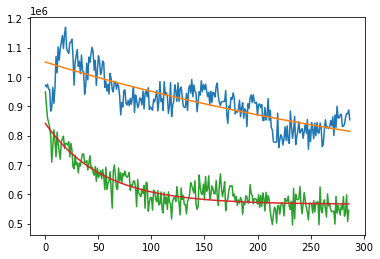

In [ ]:
def photobleaching_rate(trace, ch_0, ch_1, k, two_colour=False, do_calculate=True, type=''):
    do_smart_divide = False

    def monoExp(x, m, t, b):
        return m * np.exp(-t * x) + b

    if do_calculate:
        stack_ch0 = read(ch_0, full=True)
        ch0 = []
        for i in range(stack_ch0.shape[0]):
            I = np.sum(stack_ch0[i, :, :])
            ch0.append(I)

        p0 = (ch0[0], 0.1, 0)
        bins = np.arange(0, len(ch0), 1)
        params, cv = optimize.curve_fit(monoExp, bins, ch0, p0)

        plt.plot(ch0)
        plt.plot(monoExp(bins, *params))
        np.savetxt('photobleaching.txt', ch0)
        np.savetxt('exp_fit.txt', monoExp(bins, *params))
        print(f'Photobleaching params: decay constant, k = {params[1]}')

        if two_colour:
            stack_ch1 = read(ch_1, full=True)
            ch1 = []
            for i in range(stack_ch1.shape[0]):
                I = np.sum(stack_ch1[i, :, :])
                ch1.append(I)

            p0 = (max(ch1), 0.1, 0)
            x_max = max(range(len(ch1)), key=ch1.__getitem__)
            bins = np.arange(0, len(ch1), 1)
            params, cv = optimize.curve_fit(monoExp, bins[x_max:-1], ch1[x_max:-1], p0)
            print(f'Photobleaching params: decay constant, k = {params[1]}')

            plt.plot(ch1)
            plt.plot(monoExp(bins, *params))

        plt.show()

    else:
        if type == 'liposome':
            A0 = trace[0]
        elif type == 'protein':
            A0 = trace[25]
        else:
            print('No type...')

        bins = np.arange(0, len(trace), 1)
        fit = monoExp(bins, A0, k, 0)
        error = trace - fit
        mask = np.zeros(error.shape, dtype=bool)
        mask[np.abs(error) > 0.15] = True
        decay = np.copy(fit)
        if do_smart_divide:
            np.place(decay, mask, 1)

        corr = []
        for i, frame in enumerate(stack):
            arr = frame / fit[i]
            corr.append(arr)

        corrected_trace = trace / decay
        return corrected_trace, np.array(corr), error


ch0 = 'date/run_1_a/analysis_0/ch0_stack.tiff'
ch1 = 'date/run_1_a/analysis_0/ch1_stack.tiff'

photobleaching_rate(None, ch0, ch1, None, two_colour=True, do_calculate=True)

## Correct for colour channel register drift
Either calculate calibration or apply offset from pre-computed calibration

In [ ]:
def register(stack=None, ch_0=None, ch_1=None, warp_matrix=None, tetraspeck=True):
    if tetraspeck:
        stack = read(stack, full=True)
        ch0 = stack[..., 0:427]
        ch1 = stack[..., 428:855]
        av0 = self.average(np.array(ch0))
        av1 = self.average(np.array(ch1))
        img_aligned, warp_matrix = self.align(av0, av1)
        write(av0, 'ch0_average.tiff')
        write(av1, 'ch1_average.tiff')
        write(img_aligned, 'ch1_aligned.tiff')
        np.save('warp_matrix.npy', warp_matrix)
    else:
        warp = np.load(warp_matrix)
        print("Perforing Register Correction - deblur")
        frames_ch1 = []
        size_ch1 = ch_1.shape[0]
        for i in range(size_ch1):
            if i == size_ch1 - 1:
                print(f"Frame {i + 1} of {size_ch1}", end='\n')
            else:
                print(f"Frame {i + 1} of {size_ch1}", end='\r')
            sz = ch_1.shape

            aligned = cv2.warpAffine(ch_1[i, :, :], warp, (sz[2], sz[1]),
                                      flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
            frames_ch1.append(aligned)
        return ch_0, np.array(frames_ch1)

    
warp_matrix = 'date/warp_matrix.npy'
for analysis in batch:
    ch_0, ch_1, root = analysis
    ch_0 = read(ch_0, full=True)
    ch_1 = read(ch_1, full=True)
    ch_0, ch_1 = register(_, ch_0, ch_1, warp_matrix, tetraspeck=False)
    write(ch_1, os.path.join(root,'ch1_aligned.tiff'))

Perforing Register Correction - deblur
Frame 200 of 200
Perforing Register Correction - deblur
Frame 200 of 200
Perforing Register Correction - deblur
Frame 200 of 200
Perforing Register Correction - deblur
Frame 200 of 200


In [ ]:
def localisations_2_coords():
        ch0_stack = []
        ch1_stack = []
        for root, _, filenames in os.walk(self.args['localisations']):
            if os.path.split(root)[1] == 'ch0_locs':
                l = []
                for file in filenames:
                    l.append(int(file.split('_')[-4][1:]))
                lsort = sorted(range(len(l)), key=lambda k: l[k])

                for index in lsort:
                    img = os.path.join(root, filenames[index])
                    arr = self.read(img, full=True)
                    ch0_stack.append(arr)

            if os.path.split(root)[1] == 'ch1_locs':
                l = []
                for file in filenames:
                    l.append(int(file.split('_')[-4][1:]))
                lsort = sorted(range(len(l)), key=lambda k: l[k])

                for index in lsort:
                    img = os.path.join(root, filenames[index])
                    arr = self.read(img, full=True)
                    ch1_stack.append(arr)

        ch0_stack = np.array(ch0_stack)
        ii = np.where(ch0_stack != 0)
        return list(zip(*ii[1:3]))

def survival_analysis():
    neg_stack = []
    exp_stack = []
    for root, _, filenames in os.walk(self.args['localisations']):
        if os.path.split(root)[1] == 'ch0_locs':
            l = []
            for file in filenames:
                l.append(int(file.split('_')[-4][1:]))
            lsort = sorted(range(len(l)), key=lambda k: l[k])

            for index in lsort:
                img = os.path.join(root, filenames[index])
                arr = self.read(img, full=True)
                ii = np.where(arr != 0)
                l = list(zip(*ii[1:3]))
                exp_stack.append(len(l))
    exp = np.array(exp_stack)

    # for root, _, filenames in os.walk(self.args['localisations2']):
    #     if os.path.split(root)[1] == 'ch0_locs':
    #         l = []
    #         for file in filenames:
    #             l.append(int(file.split('_')[-4][1:]))
    #         lsort = sorted(range(len(l)), key=lambda k: l[k])
    #
    #         for index in lsort:
    #             img = os.path.join(root, filenames[index])
    #             arr = self.read(img, full=True)
    #             jj = np.where(arr != 0)
    #             l = list(zip(*jj[1:3]))
    #             neg_stack.append(len(l))
    # neg = np.array(neg_stack)

    def normalise_list(data):
        return data / data[0]
    # neg_hat = normalise_list(neg)
    exp_hat = normalise_list(exp)
    # plt.plot(neg_hat[0:100], color='green')
    # plt.plot(exp_hat[0:100], color='blue')
    np.savetxt(str(self.args['out'])+'.txt', exp_hat)
    # np.savetxt('lipo_neg_control.txt', neg_hat)
    # plt.show()

In [ ]:
def single_mol_trace():
    #ASSUMES PREPROCESSING HAS ALREADY BEEN DONE.
    # TAKES A GAIN REFERENCE CORRECTED STACK IN SINGLE CHANNEL FORMAT (currently)
    debug = True

    if self.args['input']:
        stack_0 = self.read(self.args['input'], 0, 5)
        ch0_average = self.average(stack_0)
    else:
        sys.exit("At minimum, ch0 should be provided. Ch1 is optional")

    if self.args['input2']:
        stack_1 = self.read(self.args['input2'], 0, 5)
        ch1_average = self.average(stack_1)
        two_ch = True
        print("Performing two-channel analysis")
    else:
        two_ch = False
        print("Performing single-channel analysis")

    # all_spots = []
    # for frame in range(20):
    #     spots = self.peak_finder(stack_0[frame,:,:])
    #     all_spots.append(spots)
    # all_spots = [spots for sublist in all_spots for spots in sublist]
    all_spots = self.localisations_2_coords()
    centers = self.filter_spots(stack_0[0, :, :].shape, all_spots)

    full_stack_ch0 = self.read(self.args['input'], full=True)
    ch0_ref = np.max(full_stack_ch0, axis=0)

    if two_ch:
        full_stack_ch1 = self.read(self.args['input2'], full=True)
        ch1_ref = np.max(full_stack_ch1, axis=0)
    else:
        full_stack_ch1 = None
        ch1_ref = None

    full_stack_ch0, full_stack_ch1 = self.align_and_register(full_stack_ch0, full_stack_ch1, ch0_ref, ch1_ref, two_ch=two_ch)

    ch0_maxI_al = np.max(full_stack_ch0, axis=0)
    if two_ch:
        ch1_maxI_al = np.max(full_stack_ch1, axis=0)

    if debug:
        self.write(full_stack_ch0, "corrected_ch0_stack.tiff")
        self.write(ch0_maxI_al, "ch0_max_i_proj_drift.tiff")
        self.write(ch0_ref, "ch0_max_i_proj.tiff")
        self.write(ch0_average, "ch0_early_average.tiff")
        grid = np.zeros(ch0_average.shape)
        coodinates = np.array(centers)
        new_vals = np.ones(coodinates.shape[0])*100
        grid[tuple(zip(*coodinates))] = new_vals
        self.write(grid, "ch0_peaks.tiff")

        if two_ch:
            self.write(ch1_average, "ch1_early_average.tiff")
            self.write(ch1_ref, "ch1_max_i_proj.tiff")
            self.write(ch1_maxI_al, "ch1_max_i_proj_drift.tiff")
            self.write(full_stack_ch1, "corrected_ch1_stack.tiff")

    exclude = []
    for num,spot in enumerate(centers):
        lipo_trace, lipo_bg, lipo_stack = self.intensity_trace(full_stack_ch0, spot, box=2)
        # TO DO: Remove this... make sure
        if lipo_trace is None:
            exclude.append(spot)
            continue

        if two_ch:
            protein_trace, prot_bg, protein_stack = self.intensity_trace(full_stack_ch1, spot, box=2)
            if protein_trace is None:
                exclude.append(spot)
                continue

        lipo_trace = self.normalise(lipo_trace, bg=lipo_bg)
        if two_ch:
            protein_trace = self.normalise(protein_trace, bg=prot_bg[0])

        lipo_trace, lipo_stack, lipo_residuals = self.photobleaching_rate(lipo_trace, lipo_stack, self.liposome_decay, type='liposome')

        # if two_ch:
            #protein_trace = self.photobleaching_rate(protein_trace, protein_stack, self.protein_decay, type='protein')

        #self.plot_2d(lipo_stack, protein_stack)

        lipo_trace_denoise = self.smooth(np.array(lipo_trace), type='denoise')
        if two_ch:
            protein_trace_denoise = self.smooth(np.array(protein_trace), type='butter')

        boundary_mask = self.find_boundaries(lipo_trace)
        new_fit = self.piecewise_constant(lipo_trace, boundary_mask)

        events, jumps, fit = self.extract_intensities(lipo_trace, boundary_mask)

        # self.plotting(lipo_trace, protein_trace, lipo_trace_denoise, protein_trace_denoise, lipo_residuals ignore_fit=True)

        if two_ch:
            self.plotting2(lipo_trace, lipo_trace_denoise, protein_trace, protein_trace_denoise, lipo_residuals,
                           lipo_stack, protein_stack, num, ignore_fit=True, two_ch=two_ch)
        else:
            self.plotting2(lipo_trace, lipo_trace_denoise, None, None, lipo_residuals,
                           lipo_stack, None, num, ignore_fit=True, two_ch=two_ch)

    # grid = np.zeros(ch0_average.shape)
    # coodinates = np.array(exclude)
    # new_vals = np.ones(coodinates.shape[0]) * 100
    # grid[tuple(zip(*coodinates))] = new_vals
    # self.write(grid, "peaks_excluded.tiff")

In [ ]:
# if __name__ == '__main__':
#     # Argument parser
#     ap = argparse.ArgumentParser(
#         description=textwrap.dedent('''\
#         ###########################################################################################################
#                     TIRF analysis ***VIEW*** - python programs for analysis of single molecule TIRF
#                     Developed by Charles Bayly-Jones (2022) - Monash University, Melbourne, Australia
#         ###########################################################################################################'''),
#         usage='Use python3 %(prog)s --help for more information',
#         formatter_class=argparse.RawTextHelpFormatter)

#     ap.add_argument("-i", "--input",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Single image in .tif or .tiff format
#                     e.g. photobleaching_run.tif'''))
#     ap.add_argument("-i2", "--input2",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Single image in .tif or .tiff format
#                     e.g. photobleaching_run.tif'''))
#     ap.add_argument("-o", "--out",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Output directory to store results'''))
#     ap.add_argument("-b", "--batch", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Path to directory for batch processing. Data should be organised /data/run/ch0/image.tif'''))
#     ap.add_argument("-t", "--traces", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Path to directory for batch processing. Data should be organised /data/run/ch0/image.tif'''))
#     ap.add_argument("-s", "--survival", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Path to directory for batch processing. Data should be organised /data/run/ch0/image.tif'''))
#     ap.add_argument("-g", "--gain_ref",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Is the image a stack of frames or individual frames organised by directory?'''))
#     ap.add_argument("-l", "--localisations",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Is the image a stack of frames or individual frames organised by directory?'''))
#     ap.add_argument("-l2", "--localisations2",
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Is the image a stack of frames or individual frames organised by directory?'''))
#     ap.add_argument("-z", "--zstack", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                     Is the image a stack of frames or individual frames organised by directory?'''))
#     ap.add_argument("-G", "--do_gain_ref", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                         Is the image a stack of frames or individual frames organised by directory?'''))
#     ap.add_argument("-e", "--do_calculate", action='store_true',
#                     required=False,
#                     help=textwrap.dedent('''\
#                         Path to directory for batch processing. Data should be organised /data/run/ch0/image.tif'''))

#     args = vars(ap.parse_args())
#     C = core(args)
#     if args['do_calculate']:
#         C.photobleaching_rate(None, None, None)
#     if args['batch']:
#         C.multi_colour_preprocess()
#     if args['traces']:
#         C.single_mol_trace()
#     if args['survival']:
#         C.survival_analysis()

Photobleaching rate estimation.